In [1581]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import datetime
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import linear_model
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
import time
import cPickle as pickle

%load_ext autoreload
%autoreload 2
from functions import *
from plots import *

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8  # plotsize 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [1519]:
df = pd.DataFrame.from_csv('../data_ski_in_solitude/all_feat_scaled.csv')

In [1520]:
df.skiers

2011-11-10      573.576923
2011-11-11      573.576923
2011-11-12        0.000000
2011-11-13       44.000000
2011-11-14    -1467.000000
2011-11-15    -1580.000000
2011-11-16    -1315.000000
2011-11-17    -1202.000000
2011-11-18    -1176.000000
2011-11-19       23.000000
2011-11-20      738.000000
2011-11-21     -546.000000
2011-11-22     -635.000000
2011-11-23     -265.000000
2011-11-24     1369.000000
2011-11-25     2162.000000
2011-11-26     3350.000000
2011-11-27      573.576923
2011-11-28     1909.000000
2011-11-29     1503.000000
2011-11-30     1526.000000
2011-12-01     1567.000000
2011-12-02     1721.000000
2011-12-03     3347.000000
2011-12-04     3675.000000
2011-12-05     1950.000000
2011-12-06     1830.000000
2011-12-07     1825.000000
2011-12-08     1853.000000
2011-12-09     2104.000000
2011-12-10     3566.000000
2011-12-11     3791.000000
2011-12-12     2081.000000
2011-12-13     1916.000000
2011-12-14     1940.000000
2011-12-15     1962.000000
2011-12-16     2239.000000
2

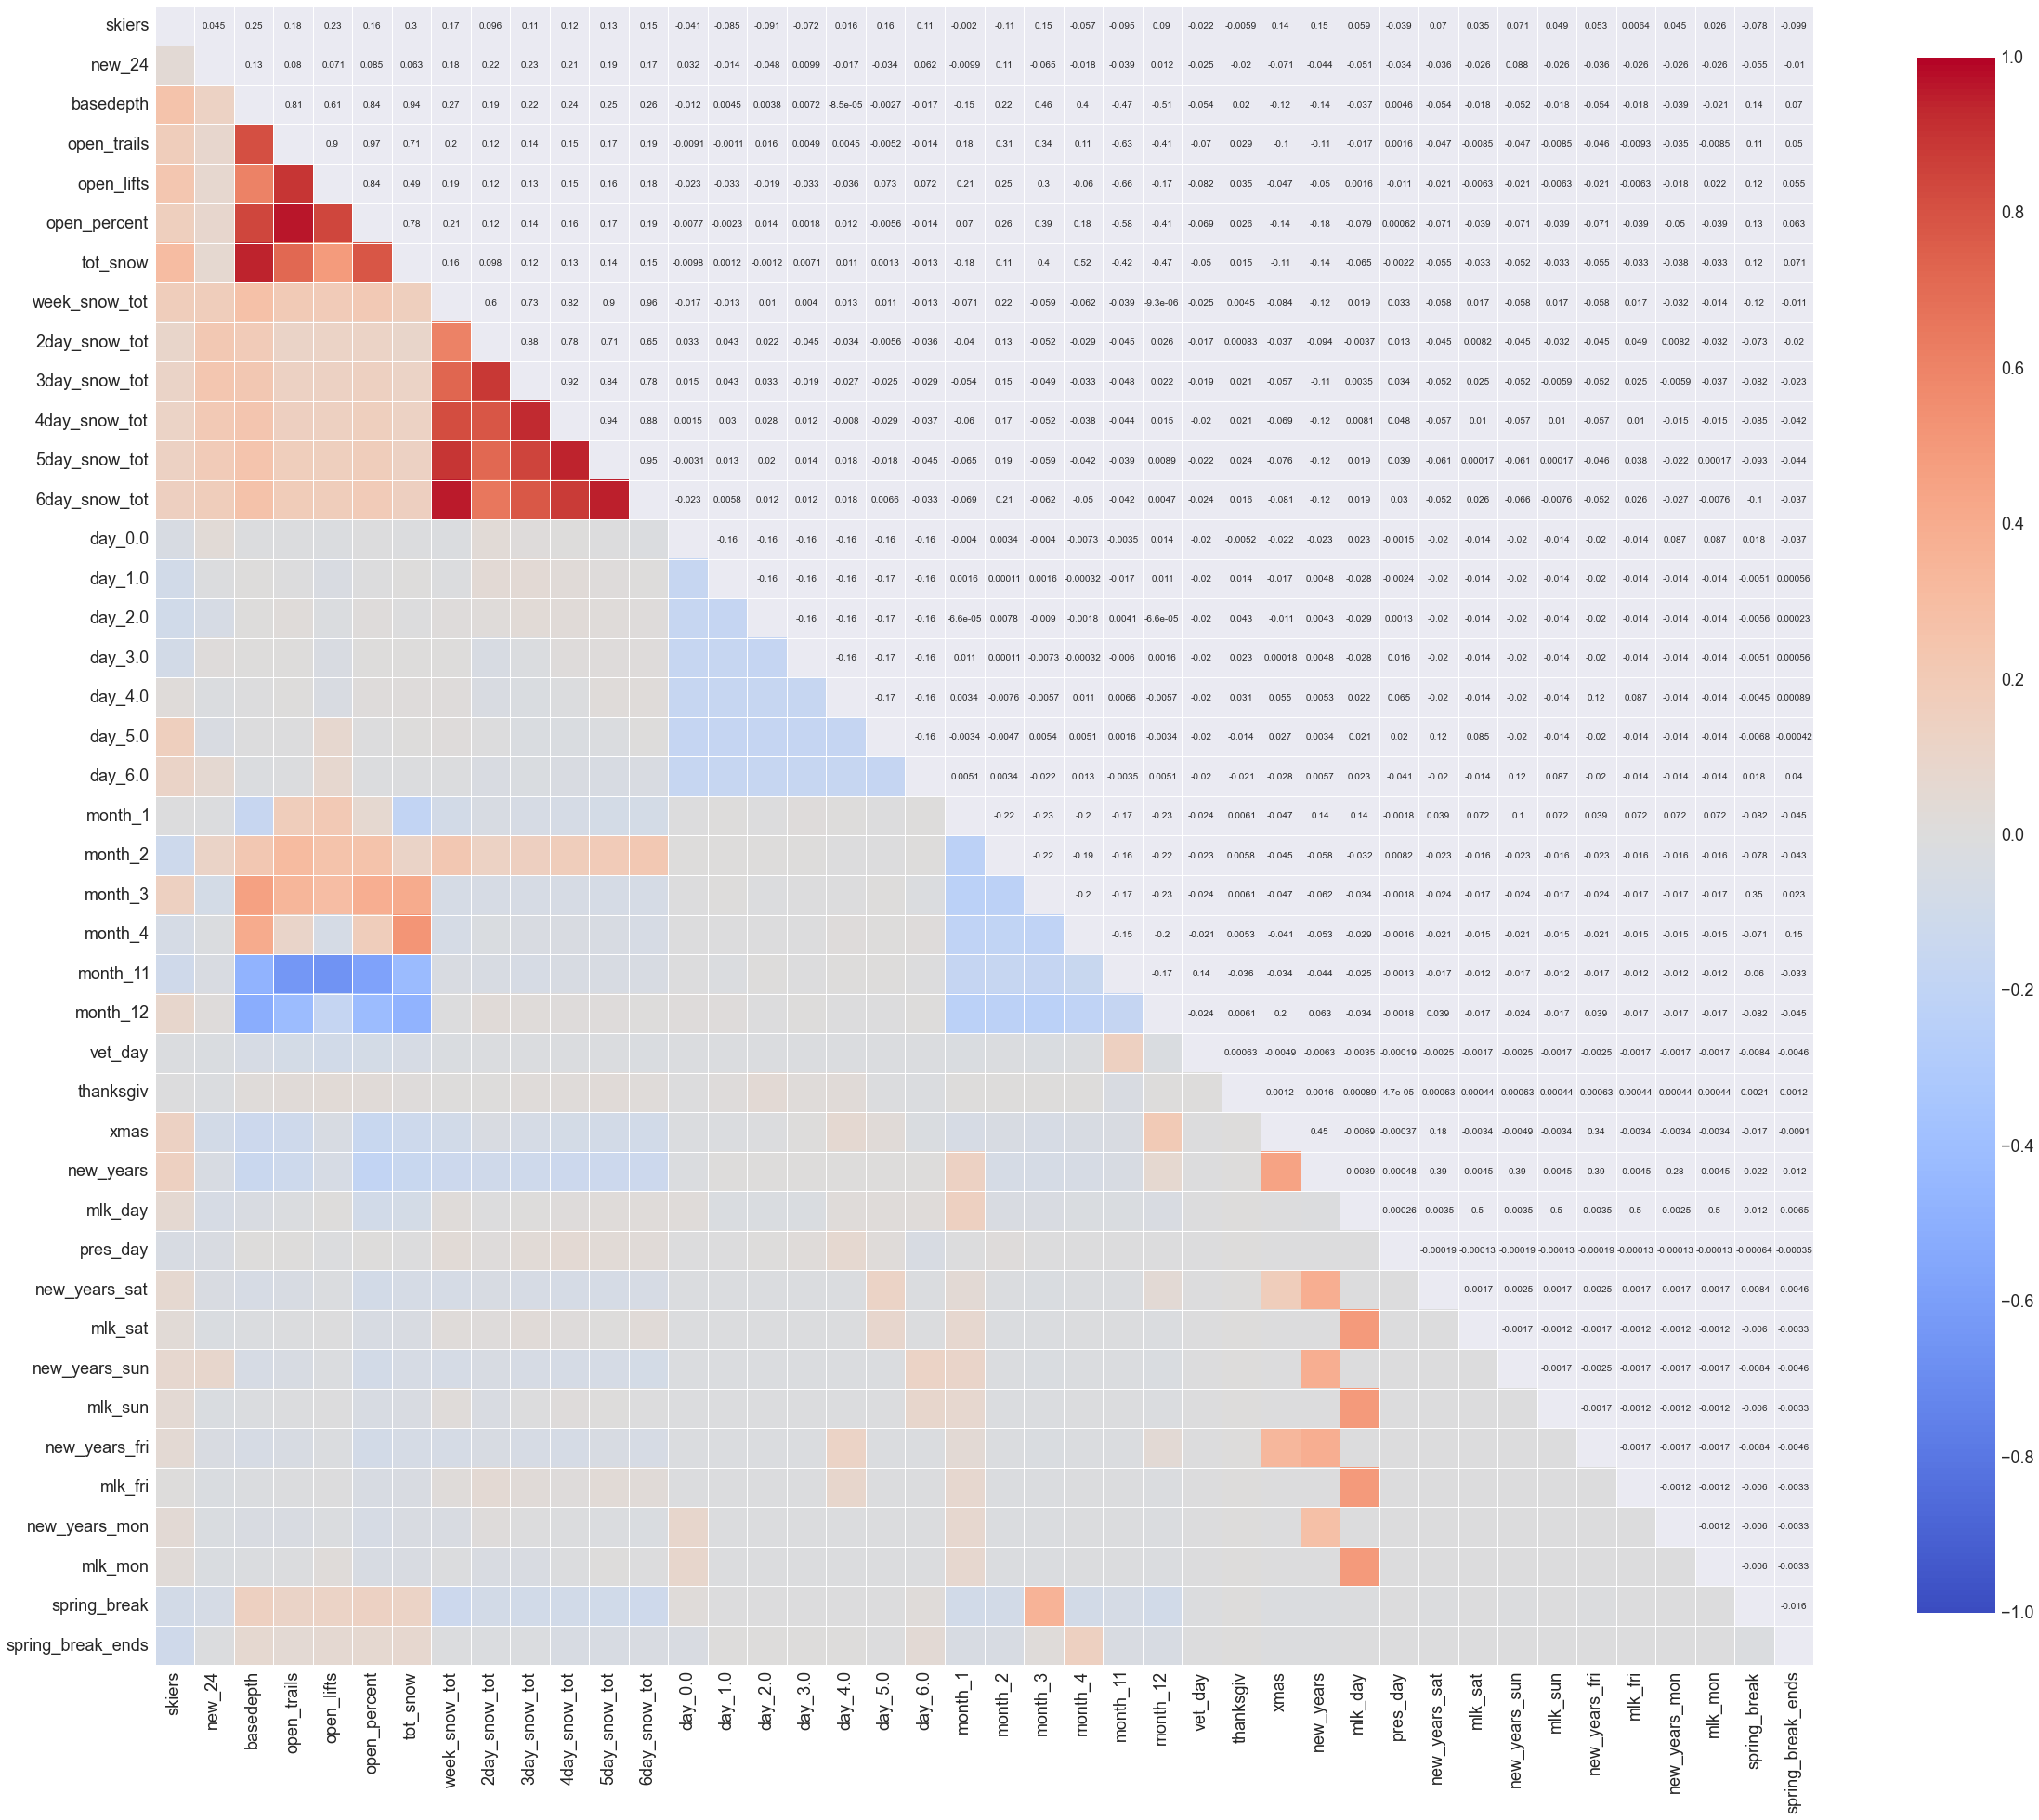

In [1521]:
f, ax = plt.subplots(figsize=(40, 40))
sns.corrplot(df, annot=True, sig_stars=False,
             diag_names=False, ax=ax)

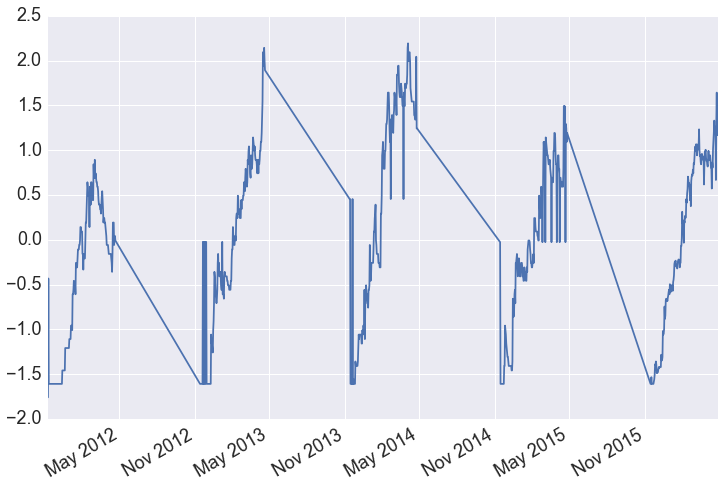

In [1522]:
df.basedepth.plot()

### Create a training and holdout set

In [1523]:
df_tr = df[df.index < datetime.datetime(2014,11,1)]
df_h = df.ix[datetime.datetime(2014,11,1):datetime.datetime(2015,5,1)]
df_fut = df.ix[datetime.datetime(2015,5,1):]

In [1524]:
df_tr.head()

,skiers,new_24,basedepth,open_trails,open_lifts,open_percent,tot_snow,week_snow_tot,2day_snow_tot,3day_snow_tot,...,new_years_sat,mlk_sat,new_years_sun,mlk_sun,new_years_fri,mlk_fri,new_years_mon,mlk_mon,spring_break,spring_break_ends
2011-11-10,573.576923,-0.728536,-1.757117,-2.267958,-2.775779,-2.060768,-1.483913,-0.5111,-0.337106,-0.380895,...,-0.049538,-0.035007,-0.049538,-0.035007,-0.049538,-0.035007,-0.035007,-0.035007,-0.170198,-0.092962
2011-11-11,573.576923,-0.267665,-0.431049,-0.562669,-0.518840,-0.710048,-0.553476,-0.5111,-0.337106,-0.380895,...,-0.049538,-0.035007,-0.049538,-0.035007,-0.049538,-0.035007,-0.035007,-0.035007,-0.170198,-0.092962
2011-11-12,0.000000,-0.728536,-1.607082,-2.267958,-2.775779,-2.060768,-1.483913,-0.5111,-0.337106,-0.380895,...,-0.049538,-0.035007,-0.049538,-0.035007,-0.049538,-0.035007,-0.035007,-0.035007,-0.170198,-0.092962
2011-11-13,44.000000,-0.271842,-1.607082,-2.267958,-2.775779,-2.060768,-1.472829,-0.5111,-0.916571,-0.380895,...,-0.049538,-0.035007,-0.049538,-0.035007,-0.049538,-0.035007,-0.035007,-0.035007,-0.170198,-0.092962
2011-11-14,-1467.000000,0.641546,-1.607082,-2.267958,-2.775779,-2.060768,-1.439577,-0.5111,-0.628616,-0.827921,...,-0.049538,-0.035007,-0.049538,-0.035007,-0.049538,-0.035007,-0.035007,-0.035007,-0.170198,-0.092962


## Forward selection

In [1574]:
lin_regr = linear_model.LinearRegression()

In [1575]:
ref_column = 'skiers'
features = list(df_tr.columns.values)
features.remove('skiers')

In [1576]:
X_tr = df_tr[columns]
y_tr = df_tr.skiers.values
X_h = df_h[columns].values

In [1577]:
fs_features, RMSE = forward_selection_lodo(lin_regr, X_tr, y_tr, 25, features)

Next best Feature:  tot_snow , RMSE:  3434.8 #: 1
Next best Feature:  month_12 , RMSE:  3257.1 #: 2
Next best Feature:  month_4 , RMSE:  3072.9 #: 3
Next best Feature:  new_years , RMSE:  2944.5 #: 4
Next best Feature:  day_6.0 , RMSE:  2827.8 #: 5
Next best Feature:  month_2 , RMSE:  2709.8 #: 6
Next best Feature:  month_3 , RMSE:  2519.4 #: 7
Next best Feature:  day_5.0 , RMSE:  2383.1 #: 8
Next best Feature:  open_percent , RMSE:  2351.4 #: 9
Next best Feature:  open_lifts , RMSE:  2283.9 #: 10
Next best Feature:  month_1 , RMSE:  2255.4 #: 11
Next best Feature:  open_trails , RMSE:  2239.9 #: 12
Next best Feature:  day_0.0 , RMSE:  2225.0 #: 13
Next best Feature:  day_4.0 , RMSE:  2215.9 #: 14
Next best Feature:  xmas , RMSE:  2208.3 #: 15
Next best Feature:  mlk_day , RMSE:  2201.9 #: 16
Next best Feature:  pres_day , RMSE:  2198.1 #: 17
Next best Feature:  new_years_mon , RMSE:  2194.8 #: 18
Next best Feature:  new_24 , RMSE:  2191.8 #: 19
Next best Feature:  day_1.0 , RMSE:  218

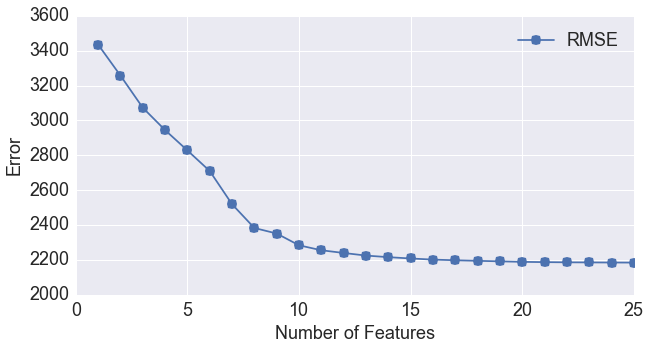

In [1578]:
plot_error_vs_features(RMSE, 'none', 'none')

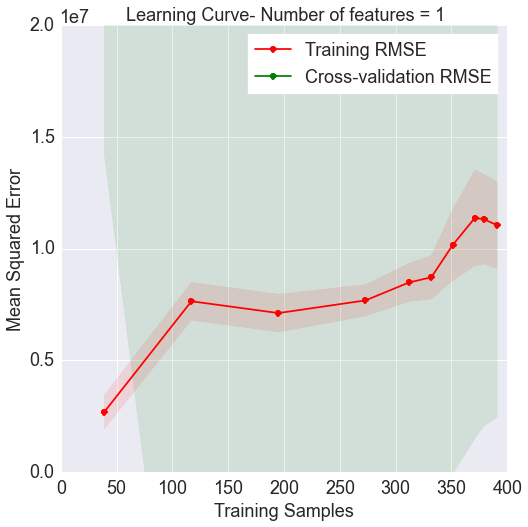

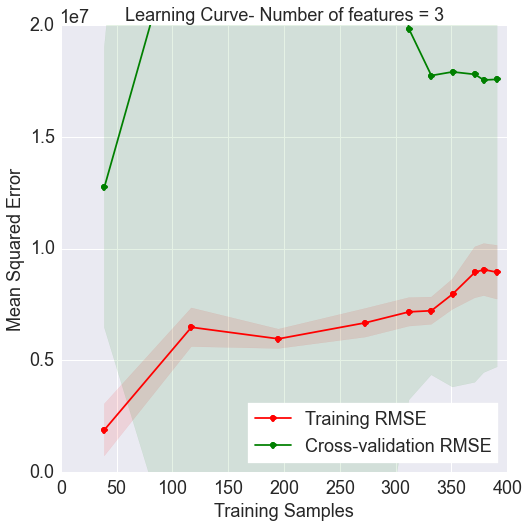

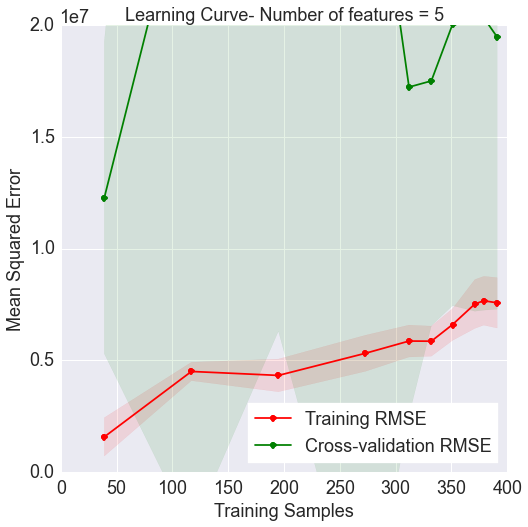

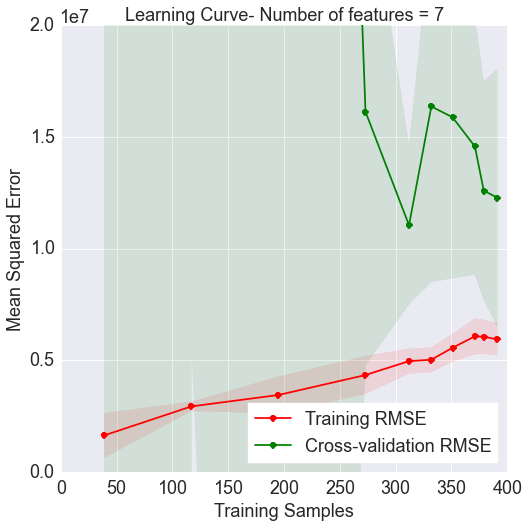

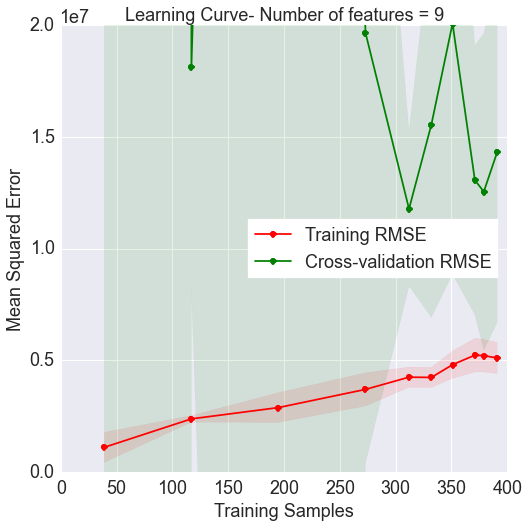

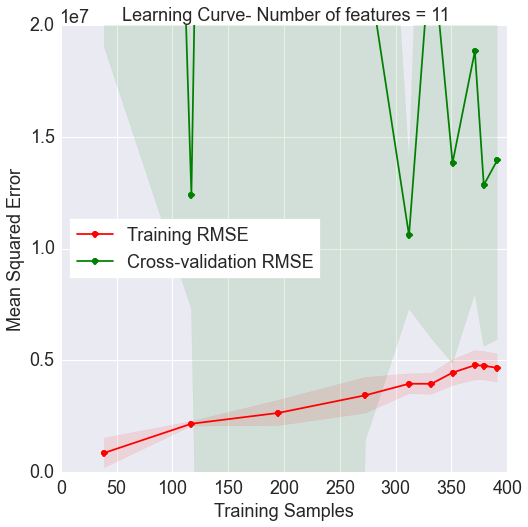

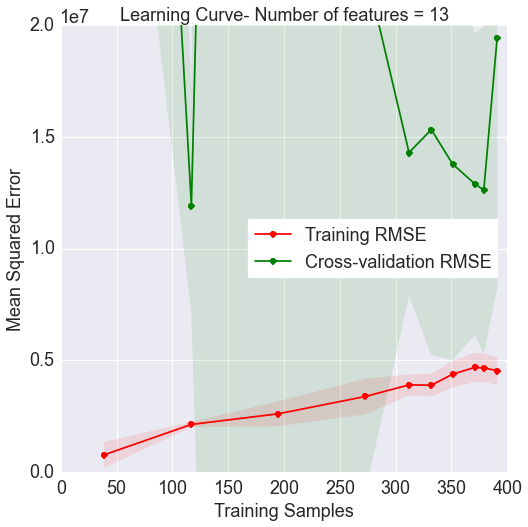

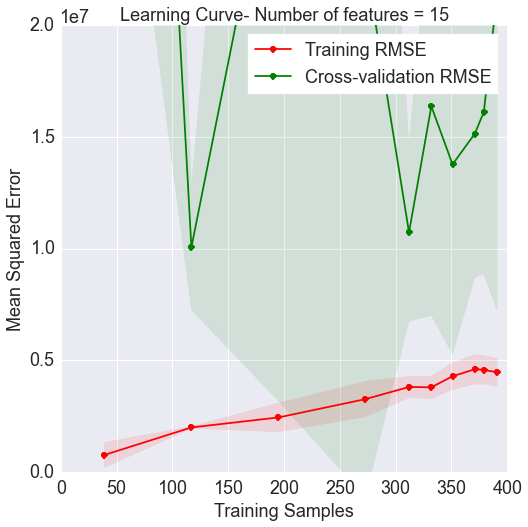

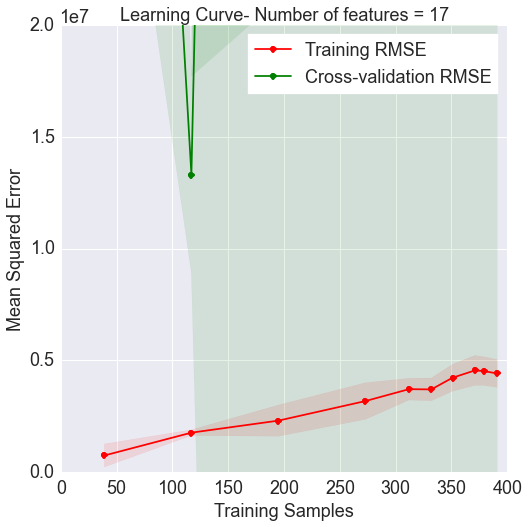

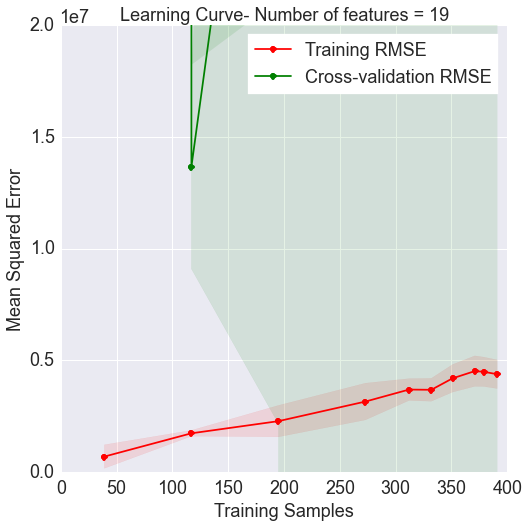

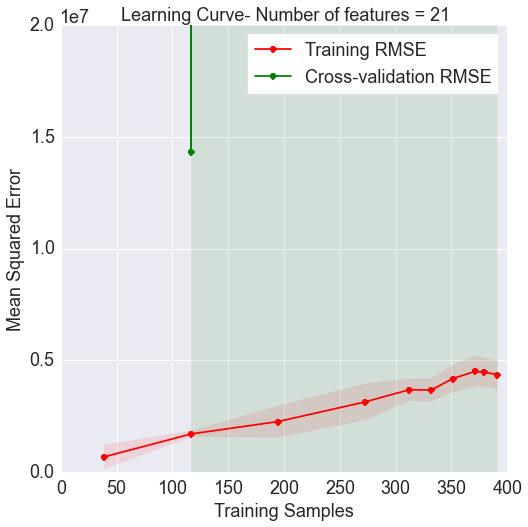

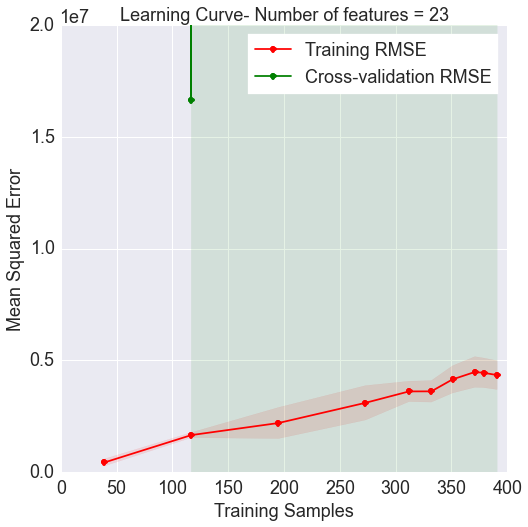

In [1592]:
i = 1
while i < 25:
    num_good_feat = i
    #df_cv_1, df_H_1 = find_fitted_cv_values_for_best_features(df_tr, ref_column)
    #fitted_vs_ref_plot(df_cv_1, i, ref_column) 
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,20000000), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 2

# Linear Regression

In [1511]:
mdl = lr.fit(X_tr, y_tr) 

In [1512]:
cv_pred = cross_val_predict(lr, X_tr, y_tr, cv = 10)

In [1514]:
cv_score = cross_val_score(lr, X_tr, y_tr, cv = 10)

In [1515]:
cv_score.mean()

-1.012596636636642e+25

In [1516]:
clf = linear_model.Lasso(alpha=0.01)
lasso = clf.fit(X_tr, y_tr)
cv_pred_lasso = cross_val_predict(lasso, X_tr, y_tr, cv = 10)

In [1517]:
pred = mdl.predict(X_tr)
df_tr['model_pred'] = pred
df_tr['cv_lin_pred'] = cv_pred
df_tr['lasso_pred'] = cv_pred_lasso

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

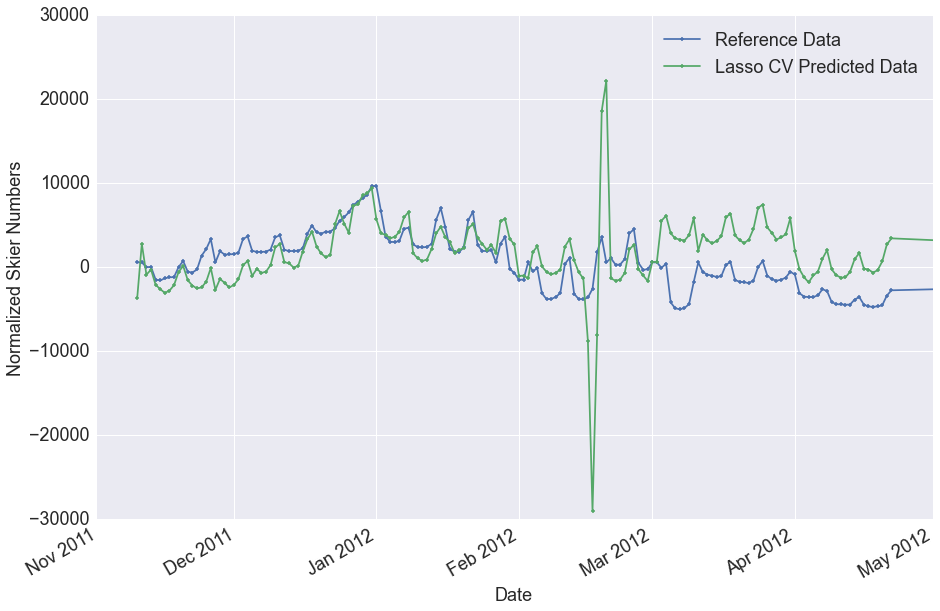

In [1518]:
plot_fitted_and_ref_vs_time(df_tr, ref_column, ['2011-11-1 00:00:00', '2012-05-1 00:00:00'])

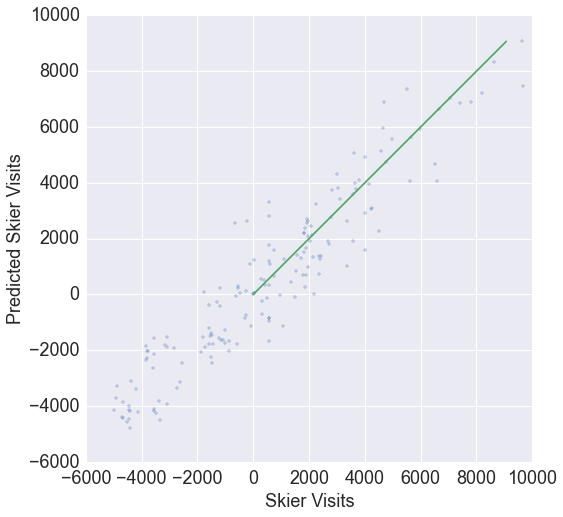

In [1053]:
fitted_vs_ref_plot(df_all, ref_column)

In [782]:
df_all.head()

,skiers,freezing_fog,heavy_snow,light_snow,mist,thunderstorm_haze,thunderstorm_snow,clear_sky,broken_sky,scattered_sky,...,new_years_fri,mlk_fri,vet_mon,new_years_mon,mlk_mon,spring_break,spring_break_ends,model_pred,cv_lin_pred,lasso_pred
2014-11-01,-59.195122,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.847222,0.013889,0.138889,...,0,0,0,0,0,0,0,950.319154,3591.108836,3597.973148
2014-11-02,-59.195122,0.043478,0.014493,0.028986,0.072464,0.028986,0.000000,0.507246,0.086957,0.289855,...,0,0,0,0,0,0,0,293.377511,2986.219794,2995.366507
2014-11-03,-59.195122,0.370968,0.048387,0.096774,0.080645,0.000000,0.032258,0.096774,0.096774,0.080645,...,0,0,0,0,0,0,0,-46.903050,1977.498779,1991.163920
2014-11-04,-59.195122,0.000000,0.000000,0.000000,0.013889,0.000000,0.000000,0.597222,0.000000,0.000000,...,0,0,0,0,0,0,0,1113.756494,3760.787462,3740.533842
2014-11-05,-59.195122,0.055556,0.000000,0.013889,0.055556,0.000000,0.000000,0.694444,0.041667,0.055556,...,0,0,0,0,0,0,0,879.956589,3641.196753,3643.622627


### Export Model

In [1342]:
#saving pickle file as .p is best
pickle_out = open('lin_regr.pkl', 'wb')
pickle.dump(mdl, pickle_out)
pickle_out.close()

# Export Data

In [783]:
df_out = df_all.drop(['model_pred','skiers'], axis=1)

In [784]:
df_out.to_csv('../webpage_ski/df_all_features.csv')